In [342]:
import sys

In [343]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [344]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [345]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/MyDrive/m146hw1'] 
### ========== TODO : END ========== ###


In [346]:
from nutil import *

In [347]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [348]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [349]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        self.probabilities_ = Counter(y)[0]/(Counter(y)[0] + Counter(y)[1])
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        #size needs to be 2 for 1 and 0, shape is given by X[0], 
        y = np.random.choice(2, X.shape[0], p = [self.probabilities_, 1-self.probabilities_])
        ### ========== TODO : END ========== ###

        return y


In [350]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [351]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)
    train_error = 0
    test_error = 0
    f1_score = 0
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        train_error += 1 - metrics.accuracy_score(y_train, y_train_pred, normalize=True)     
        test_error += 1 - metrics.accuracy_score(y_test, y_test_pred, normalize=True)
        f1_score += metrics.f1_score(y_test, y_test_pred, average='micro')
    train_error = train_error/ntrials
    test_error = test_error/ntrials
    f1_score = f1_score/ntrials

    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [352]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error: 0.153
	-- training error: 0.195
	-- training error: 0.213
Investigating various classifiers...
    For Majority Vote classifier:
	-- training error: 0.240
	-- testing error: 0.240
	-- f1_score: 0.760
    For Random classifier:
	-- training error: 0.375
	-- testing error: 0.382
	-- f1_score: 0.618
    For Descision Tree classifier:
	-- training error: 0.000
	-- testing error: 0.205
	-- f1_score: 0.795
    For K Neighbors = 3 classifier:
	-- training error: 0.157
	-- testing error: 0.284
	-- f1_score: 0.716
    For K Neighbors = 5 classifier:
	-- training error: 0.202
	-- testing error: 0.259
	-- f1_score: 0.741
    For K Neighbors = 7 classifier:
	-- training error: 0.218
	-- testing error: 0.248
	-- f1_score: 0.752
Finding the best k...
	-- 

No handles with labels found to put in legend.


	-- training error for 49-Nearest Neighbors...: 0.240
	-- training error for 51-Nearest Neighbors...: 0.240


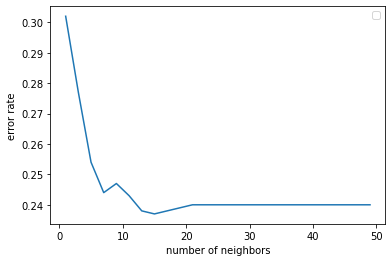

Investigating depths...
Done


In [353]:

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/MyDrive/m146hw1/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    



    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    

    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    #plot_histograms (X, y, Xnames=Xnames, yname=yname)
    




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    
    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    rand_clf = RandomClassifier()
    rand_clf.fit(X, y)
    y_pred = rand_clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(X, y)
    y_pred = clf.predict(X) 
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X, y)
    y_pred = clf.predict(X) 
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X, y)
    y_pred = clf.predict(X) 
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X, y)
    y_pred = clf.predict(X) 
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')
    big_error = error(MajorityVoteClassifier(), X, y)
    print('    For Majority Vote classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    
    big_error = error(RandomClassifier(), X, y)
    print('    For Random classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    big_error = error(DecisionTreeClassifier(criterion="entropy"), X, y)
    print('    For Descision Tree classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    big_error = error(KNeighborsClassifier(n_neighbors=3), X, y)
    print('    For K Neighbors = 3 classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    big_error = error(KNeighborsClassifier(n_neighbors=5), X, y)
    print('    For K Neighbors = 5 classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    big_error = error(KNeighborsClassifier(n_neighbors=7), X, y)
    print('    For K Neighbors = 7 classifier:')
    print('\t-- training error: %.3f' % big_error[0])
    print('\t-- testing error: %.3f' % big_error[1])
    print('\t-- f1_score: %.3f' % big_error[2])

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    count = 1
    knns = []
    errors = []
    while (count <= 50):
      knns.append(count)
      clf = KNeighborsClassifier(n_neighbors=count)
      count += 2
      c_val_score = cross_val_score(clf, X, y, cv=10)
      errors.append(1 - sum(c_val_score)/float(len(c_val_score)))
      print('\t-- training error for %g-Nearest Neighbors...: %.3f' % (count, 1-np.mean(c_val_score))) 
    
    

    plt.plot(knns,errors)
    plt.xlabel("number of neighbors")
    plt.ylabel("error rate")
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    
    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
